# Long Short-Term Memory Network with Keras

LSTM은 Backpropagation Through Time (BPTT)를 통해서 학습을 하며, vanishing gradient problem을 극복합니다.<br>
일반적인 Deep Learning에서 사용하는 Neurons들은 없고, layers들로 연결된 Memory Block을 갖고 있습니다. 

Block은 gates의 요소를 갖고 있으며, Gates는 block의 state를 관리하게 됩니다.<br>
일반적으로 다음과 같은 gates를 갖고 있습니다.

* Forget Gate: 어떤 정보를 버릴지 정합니다.
* Input Gate: Input 데이터에서 어떤 값들을 memory state에 업데이트할지 결정합니다.
* Output Gate: Input값과 memory block에 기초하여 어떤 결과값(output)을 낼지 결정합니다.


In [1]:
%pylab inline
%env CUDA_VISIBLE_DEVICES=""
import numpy as np
import pandas as pd
import os
import shutil
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization
from keras.layers import LSTM, Bidirectional
from keras.layers.core import Reshape
from keras.callbacks import History, TensorBoard


from keras.utils.vis_utils import plot_model
from keras.utils.vis_utils import model_to_dot
from IPython.display import display
from IPython.display import SVG, Image

np.random.seed(0) # fix the random number

Populating the interactive namespace from numpy and matplotlib
env: CUDA_VISIBLE_DEVICES=""


Using TensorFlow backend.


## Configuration

In [2]:
BATCH = 12
MAXLEN = 32
LOOK_BACK = 1

## Data

International Airline Pessengers

In [3]:
# Load Data
data = pd.read_csv('../../data/time-series/international-airline-passengers.csv', 
                   names=['passenger'],
                   skiprows=1, usecols=[1])

data = data.as_matrix()

# Normalize Data using Min-Max Scaler 
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
data = data.astype('float64')

# Seperate Train and Test Data
def split_train_test(data, train_size_p=0.7, batch=BATCH):
    _size = int(len(data) * train_size_p) # 144
    train, test = data[:_size], data[_size-batch:] # 100, 44
    return train, test

def to_timeseries(x, batch:int):
    n = len(x)
    train = np.zeros((n-2*batch, batch, 1))
    test = np.zeros((n-2*batch, batch, 1))
    
    for i in range(n - 2*batch):
        
        train[i] = x[i:i+batch]
        test[i] = x[i+batch:i+batch+batch]
        
    return train, test

def augment(x, y):
    n_type = 5
    n = x.shape[0]
    aug_x = np.zeros((n*n_type, BATCH, 1), dtype='float64')
    aug_y = np.zeros((n*n_type, BATCH, 1), dtype='float64')
    
    # Original
    aug_x[:n] = x
    aug_y[:n] = y
    
    # Sqaured
    aug_x[n:n*2] = x**2
    aug_y[n:n*2] = y**2
    
    # Increase 
    aug_x[n*2:n*3] = x + 0.2
    aug_y[n*2:n*3] = y + 0.2
    
    # Decrease 
    aug_x[n*3:n*4] = x - 0.3
    aug_y[n*3:n*4] = y - 0.3
    
    # Inverse
    aug_x[n*4:n*5] = 1 - x
    aug_y[n*4:n*5] = 1 - y
    return aug_x, aug_y

train, test = split_train_test(data)
train_x, train_y = augment(*to_timeseries(train, batch=BATCH))
test_x, test_y = to_timeseries(test, batch=BATCH)

print('train:  ', train.shape)
print('test:   ', test.shape)
print('train_x:', train_x.shape)
print('train_y:', train_y.shape)
print('test_x: ', test_x.shape)
print('test_y: ', test_y.shape)

train:   (100, 1)
test:    (56, 1)
train_x: (380, 12, 1)
train_y: (380, 12, 1)
test_x:  (32, 12, 1)
test_y:  (32, 12, 1)


/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


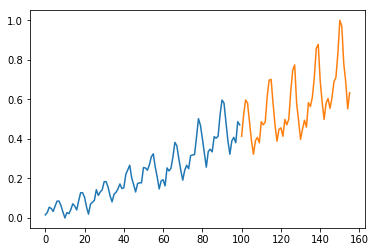

In [4]:
x1 = range(len(train))
x2 = range(len(train), len(train) + len(test))
plot(x1, train)
plot(x2, test)

## TensorBoard

In [5]:
# History
tensorboard_filepath = '/tmp/international_airline_passenger_logs'
if os.path.exists(tensorboard_filepath):
    shutil.rmtree(tensorboard_filepath)

history = History()
tensorboard = TensorBoard('/tmp/international_airline_passenger_logs')

## Model

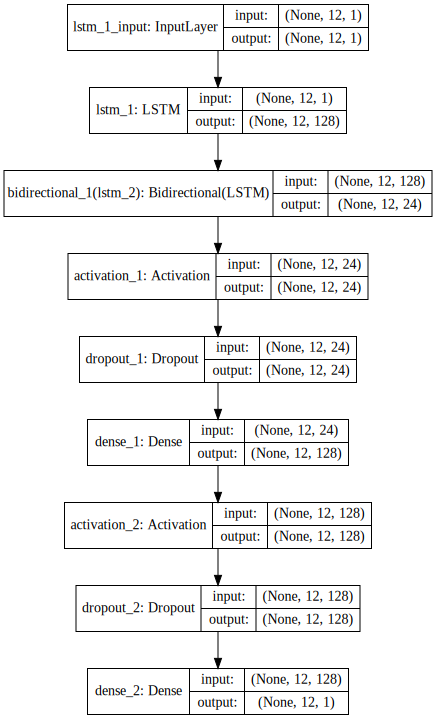

In [ ]:
def create_model():
    np.random.seed(0)
    model = Sequential(name='LSTM Model')
    model.add(LSTM(128,  return_sequences=True, # kernel_regularizer='l1',
                            batch_input_shape=(None, BATCH, 1)))
    
    model.add(Bidirectional(LSTM(12, return_sequences=True)))
    model.add(Activation('selu'))
    model.add(Dropout(0.3))
    
    model.add(Dense(128))
    model.add(Activation('selu'))
    model.add(Dropout(0.1))
    
    model.add(Dense(1))
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# # Visualization
model = create_model()
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## Training for Normalized Data

In [ ]:
model = create_model()
model.fit(train_x, train_y, epochs=100, batch_size=BATCH, verbose=2, callbacks=[history, tensorboard])

Epoch 1/100
0s - loss: 0.0266
Epoch 2/100
0s - loss: 0.0097
Epoch 3/100
0s - loss: 0.0077
Epoch 4/100
0s - loss: 0.0069
Epoch 5/100
0s - loss: 0.0061
Epoch 6/100
0s - loss: 0.0064
Epoch 7/100
0s - loss: 0.0059
Epoch 8/100
0s - loss: 0.0057
Epoch 9/100
0s - loss: 0.0051
Epoch 10/100
0s - loss: 0.0049
Epoch 11/100
0s - loss: 0.0048
Epoch 12/100
0s - loss: 0.0050
Epoch 13/100
0s - loss: 0.0047
Epoch 14/100
0s - loss: 0.0048
Epoch 15/100
0s - loss: 0.0044
Epoch 16/100
0s - loss: 0.0046
Epoch 17/100
0s - loss: 0.0043
Epoch 18/100
0s - loss: 0.0045
Epoch 19/100
0s - loss: 0.0045
Epoch 20/100
0s - loss: 0.0046
Epoch 21/100
0s - loss: 0.0043
Epoch 22/100
0s - loss: 0.0043
Epoch 23/100
0s - loss: 0.0044
Epoch 24/100
0s - loss: 0.0041
Epoch 25/100
0s - loss: 0.0039
Epoch 26/100
0s - loss: 0.0041
Epoch 27/100
0s - loss: 0.0042
Epoch 28/100
0s - loss: 0.0042
Epoch 29/100
0s - loss: 0.0041
Epoch 30/100
0s - loss: 0.0039
Epoch 31/100
0s - loss: 0.0039
Epoch 32/100
0s - loss: 0.0038
Epoch 33/100
0s -

In [ ]:
plot(history.history['loss'], label='loss')
title('loss history')
xlabel('step')
ylabel('loss')
# ylim(0, 0.01)
grid()
legend()

## Evaluate normalized data

In [ ]:
def evaluate(model, scaler, x, y_true):
    y_pred = model.predict(x)
    
    _y_pred = y_pred.reshape(-1, 1)
    _y_true = y_true.reshape(-1, 1)
    
    print('MSE:', mean_squared_error(_y_true, _y_pred))
    print('R^2:', r2_score(_y_true, _y_pred))
    return y_pred.reshape(-1, BATCH, 1)

print('[Evaluate Training]')
train_pred = evaluate(model, scaler, train_x, train_y)

print('\n[Evaluate Test]')
test_pred = evaluate(model, scaler, test_x, test_y)

In [ ]:
def plot_result(x, y_true, y_pred):
    x = x.reshape((-1, BATCH))
    y_pred = y_pred.reshape((-1, BATCH))
    
    fig, plots = subplots(3, 4)
    plots = plots.reshape(-1)
    fig.set_figwidth(14)
    fig.set_figheight(4)
    
    _x1 = np.arange(x.shape[1])
    _x2 = np.arange(len(_x1), len(_x1) + y_true.shape[1])
    
    for p in plots:
        idx = np.random.randint(len(x))  
        p.plot(_x1, x[idx], color='#555555', label='train')
        p.plot(_x2, y_true[idx], color='#555555', label='test')
        p.plot(_x2, y_pred[idx], color='red', label='test_true')
        
plot_result(train_x, train_y, train_pred)
plot_result(test_x, test_y, test_pred)


In [ ]:
def predict(model):
    x = train_x[-len(test_y):]
    y_pred = model.predict(x)
    
    _y_true = test_y.reshape(-1, 1)
    _y_pred = y_pred.reshape(-1, 1)
    
    print('MSE:', mean_squared_error(_y_true, _y_pred))
    print('R^2:', r2_score(_y_true, _y_pred))
    
predict(model)